In [1]:
from IPython.display import Image

from matplotlib import pyplot as plt
import numpy as np
from numpy.random import normal, binomial, choice
import pandas as pd
from scipy import stats
import seaborn as sns


px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
plt.rcParams["figure.figsize"] = (600 * px, 400 * px)
%matplotlib widget

## Chapter 4: Dynamic Programming

- **Dynamic Programming (DP)** refers to a collection of algorithms that can be used to compute optimal policies given a perfect model of an environment as a **Markov Decision Process (MDP)**.
  - Classical DP is limited because of the assumption of a perfect model of the environment and because of great computational expense, but it is still important theoretically.
  - In this chapter, the focus is on how DP can be used to compute value functions in a finite MDP.
    - DP algorithms are obtained by turning Bellman equations into update rules for improving approximations of value functions.
    - Optimal policies can be easily found once optimal value functions are found (the optimal state-value function, $v_*(s)$, and/or the optimal action-value function, $q_*(s, a)$ ) which satisfy the Bellman optimality equations: 
    $$
    \begin{equation}\begin{aligned}
    v_*(s) &= \underset{a}{\operatorname{max}} \mathbb{E} \left[R_{t+1} + \gamma v_*(S_{t+1}) \bigm| S_t = s, A_t = a \right] \\
    &= \underset{a}{\operatorname{max}} \sum_{s', r} p(s',r \mid s, a) \left[r + \gamma v_*(s') \right]
    \end{aligned}\end{equation}\tag{4.1}
    $$
    
    $$
    \begin{equation}\begin{aligned}
    q_*(s, a) &= \mathbb{E} \left[R_{t+1} + \gamma \underset{a}{\operatorname{max}} q_*(S_{t+1}, a') \bigm| S_t = s, A_t = a \right] \\
    &= \sum_{s', r} p(s',r \mid s, a) \left[r + \gamma \underset{a}{\operatorname{max}} q^*(s', a') \right]
    \end{aligned}\end{equation}\tag{4.2}
    $$

## 4.1 Policy Evaluation (Prediction)

  - **Policy evaluation** (aka **prediction**) refers to how to compute $v_\pi(s)$ for an arbitrary policy $\pi$.
  - Consider a sequence of approximate value functions at certain states, $v_k, v_{k+1}, v_{k+2}, . . .$, each mapping $S+$ to $\mathbb{R}$. The initial approximation, $v_0$, is chosen arbitrarily (except that the terminal state, if any, must be given value 0), and each successive approximation is obtained by using the Bellman equation for $v_\pi$ as an update rule. Recall from Chapter 3 that for $s \in S$:
  $$
  \begin{equation}\begin{aligned}
  v_\pi(s) &= \mathbb{E}_\pi \left[G_t \mid S_t = s \right]
  \end{aligned}\end{equation}
  $$
  
  so
  
  $$
  \begin{equation}\begin{aligned}
  v_\pi(s) &= \mathbb{E}_\pi \left[R_{t+1} + \gamma v_\pi(S_{t+1}) \mid S_t = s \right] \\
  &= \sum_a \pi(a \mid s) \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma v_\pi(s') \right]
  \end{aligned}\end{equation}\tag{4.4}
  $$
  
  so
  
  $$
  \begin{equation}\begin{aligned}
  v_{k+1}(s) &= \mathbb{E}_\pi \left[R_{t+1} + \gamma v_k(S_{t+1}) \mid S_t = s \right] \\
  &= \sum_a \pi(a \mid s) \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma v_k(s') \right]
  \end{aligned}\end{equation}\tag{4.5}
  $$
  
  - This procedure/algorithm is known as **iterative policy evaluation**. 
    - Each old value of $s$ is replaced with a new value obtained from the old values of $s$'s successor states and the expected immediate rewards along all the possible next-step transitions under the policy: this is known as **expected update**.
      - There are several different kinds of expected updated, depending on 1) the update of just a state (as here in a state-value function update) or state-action pair (as in an action-value function update) and 2) the way in which the successor states' estimated values are combined.
      - All updates in DP are called "expected" because they are based on an expectation over _all_ possible next states, rather than a subset.
  - The existence and uniqueness of $v_\pi$ is guaranteed as long as $\gamma < 1$ or state termination is guaranteed. The sequence $\{v_k\}$ can be shown to converge to $v_\pi$ as $k \rightarrow \infty$ under the same $v_\pi$ existence and uniqueness conditions.
  - Programming iterative policy evaluation:
    - 2 ways to update: 
      - 1) via a "copy": use two arrays, one holding the old values $v_k(s)$ and one holding the new values $v_{k+1}(s)$ such that the new values can be computed without the old values changing.
      - 2) via a "view": use a single-array, and do "in-place" updates. 
        - This method is more memory-efficient and typically converges faster than the above method since it uses new data as soon as it is available, but the order in which states have their values updated has a significant influence on the rate of convergence.
    - Terminate after some number of steps or when the quantity $\operatorname{max}_{s \in S} [v_{k+1}(s) - v_k(s)]$ is less than some threshold.

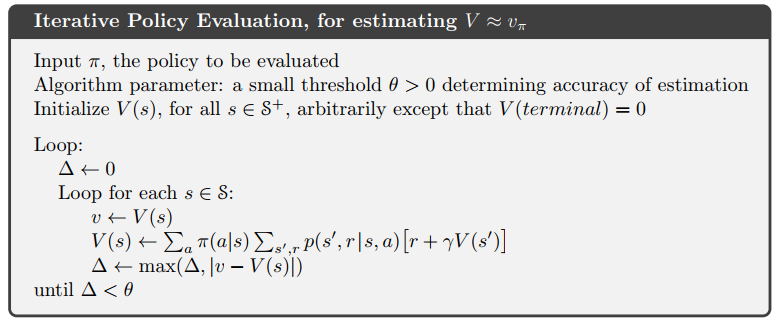

In [2]:
Image(r"images/iterative_policy_evaluation_pseudocode.png", width=600)

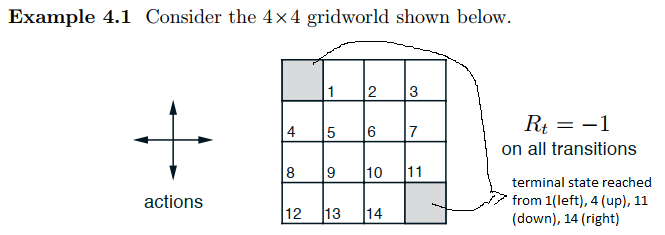

In [3]:
Image(r"images/gridworld_example.png", width=600)

In [6]:
# Implement iterative policy evaluation for the gridworld from example 4.1

# Setting things up as below solves the more general cases where:
# 1) the number of actions across different states varies
# 2) the number of possible successor states across different state-action pairs varies

# `state_action_trans` links each state-action pair to its possible successor states.
# state-action = row-column, where the columns [0:3] represent "up", "right", "down",
# and "left" actions, respectively.
# (In this case, there is only one possible successor state for each state-action pair;
# if there were more, i.e. if we had multiple possible transitions for (s' | s, a),
# then `state_action_trans` would be an array of arrays).
# "14" represents the terminal state.
state_action_trans = np.array(
    (
        (0, 1, 4, 14),
        (1, 2, 5, 0),
        (2, 2, 6, 1),
        (14, 4, 7, 3),
        (0, 5, 8, 3),
        (1, 6, 9, 4),
        (2, 6, 10, 5),
        (3, 8, 11, 7),
        (4, 9, 12, 7),
        (5, 10, 13, 8),
        (6, 10, 14, 9),
        (7, 12, 11, 11),
        (8, 13, 12, 11),
        (9, 14, 13, 12),
        (14, 14, 14, 14),
    )
)
# The reward for each possible transition in `state_action_trans`.
state_action_rewards = np.zeros_like(state_action_trans)
state_action_rewards[0:-1, :] -= 1
# The transition probabilities for each possible transition in `state_action_trans`.
state_action_trans_p = np.ones_like(state_action_trans)
# Equiprobable action policy for all four actions, regardless of state.
policy = np.ones_like(state_action_trans) * 0.25
state_values = np.zeros((state_action_trans.shape[0]))
gamma = 1  # episodic, nondiscounted task
# After each sweep through entire state-space, terminate policy evaluation if
# `delta` < `term_thresh`
term_thresh = 0.01

# Perform iterative policy evaluation
iter_ct = 0
max_iter_ct = 100
end_flag = False
while not end_flag:
    iter_ct += 1
    delta = 0
    for state in range(len(state_values)):
        old_val = state_values[state]
        # Compute successor state value term for all possible successor states
        successor_state_set = state_action_trans[state]
        ss_term_vals = np.zeros(policy.shape[1])
        for i, s_s in enumerate(successor_state_set):
            ss_term_vals[i] = np.sum(
                state_action_trans_p[state, i]
                * (state_action_rewards[state, i] + gamma * state_values[s_s])
            )
        state_values[state] = np.sum(policy[state] * ss_term_vals)
        delta = np.max(np.abs(np.array((delta, (old_val - state_values[state])))))
    if (delta < term_thresh) or (iter_ct == max_iter_ct):
        end_flag = True
print(f"Number iterations: {iter_ct}\nState values: {state_values}")

Number iterations: 62
State values: [-13.934831   -19.90631084 -21.89687771 -13.934831   -17.92002909
 -19.91316996 -19.91416281 -19.90631084 -19.91316996 -17.92673135
 -13.94529672 -21.89687771 -19.91416281 -13.94529672   0.        ]


### 4.1 Exercises

*Exercise 4.1: In Example 4.1, if $\pi$ is the equiprobable random policy, what is $q_\pi(11, down)$?
What is $q_\pi(7, down)$?*

From equation 3.13 and exercise 3.13 (see `ch3.ipynb` for solving $q_\pi(s, a)$ in terms of $v_\pi$), we get:
$$
q_\pi(s, a) = \sum_{s', r} p(s', r \mid s, a)[r + \gamma v_\pi(s')]
$$
(which is equal to 4.4 but without the initial term for summing over all possible actions from state $s$ according to the policy $\pi$)

So, for $q_\pi(11, down)$, we plug in:
$$\begin{aligned}
p(s', r \mid s, a) &= 1 \\
r &= -1 \\
\gamma &= 1 \\
v_\pi(s') &= 0 \text{ (terminal state) }
\end{aligned}$$
so we get 
$$\begin{aligned}
q &= (1) * (-1 + 1 * 0) &= -1
\end{aligned}$$


And for $q_\pi(7, down)$, we plug in:
$$\begin{aligned}
p(s', r \mid s, a) &= 1 \\
r &= -1 \\
\gamma &= 1 \\
v_\pi(s') &= v_\pi(11)
\end{aligned}$$
so we get 
$$\begin{aligned}
q &= (1) * (-1 + 1 * v_\pi(11)) &= -1 + v_\pi(11)
\end{aligned}$$

*Exercise 4.2: In Example 4.1, suppose a new state 15 is added to the gridworld just below state 13, and its actions, `left`, `up`, `right`, and `down`, take the agent to states 12, 13, 14, and 15, respectively. Assume that the transitions from the original states are unchanged. What, then, is $v_\pi$(15) for the equiprobable random policy? Now suppose the dynamics of state 13 are also changed, such that `down` from state 13 takes the agent to the new state 15. What is $v_\pi(15)$ for the equiprobable random policy in this case?*

In the first case (if we plug in the values for the states from Figure 4.1 (below)):
$$\begin{aligned}
v_\pi(15) &= -1 + [(0.25) \times [v_\pi(12) + v_\pi(13) + v_\pi(14) + v_\pi(15)] \\
&= -1 + [(0.25) \times [-20 + -22 + -14 + v_\pi(15)] \\
&= -15 + 0.25(v_\pi(15)) \\
&= \frac{-15}{0.75} = -20
\end{aligned}$$

In the second case, $v_\pi(13)$ is equal to what it was in the first case: -20. This is because we have simply replaced it's move to itself (with value = -20) to a move to 15 (also with value = -20). So $v_\pi(15)$ = -20 still.

*Exercise 4.3: What are the equations analogous to (4.3), (4.4), and (4.5) for the action-value function $q_\pi$ and its successive approximation by a sequence of functions $q_0, q_1, q_2, . . .$?*

This is the probability of all successor states and rewards given the current state and action, times (those rewards plus gamma times the sum of the action-values of all possible succesor actions multiplied by the probabilities of those actions as determined by the policy):
$$\begin{aligned}
q_\pi(s, a) &= \mathbb{E}_\pi\left[R_{t+1} + \gamma q_\pi(S_{t+1}, A_{t+1}) \mid S_t = s, A_t = a \right] \\
&= p(s', r \mid s, a) \left[r + \gamma \sum_{a'} \pi(a' \mid s') q_\pi(s', a') \right]
\end{aligned}$$

and we can set $q_{k+1}(s, a)$ = $q_k(s,a)$ as an update rule (similar to how it's done for $v_{k+1}(s)$), such that we continuously sweep through the state-action space, updating each state-action pair one-by-one, which serves as "trickle down" updates of successor state-action pairs of the next state-action pair values to be updated.

## 4.2 Policy Improvement

- Over time we want to find increasingly improving policies, and we can do this by using the value function for a current policy.
- One way to compare policies is to choose an action $a \neq \pi(s)$ then follow $\pi$ for all subsequent states, and compare the resulting return (or value function(s)) to the return (or value function(s)) if we had followed $\pi$ from $s$.
- We can extend this to consider changes at all states and to all possible actions: we can follow a greedy policy ($\pi'$ from $\pi$) that selects at each state the action that maximizes $q_\pi(s, a)$:
$$\begin{aligned}
\pi'(s) &= \underset{a}{\operatorname{argmax}} q_\pi(s, a) \\
&= \underset{a}{\operatorname{argmax}} \sum_{s', r} p(s', r \mid s, a)[r + \gamma v_\pi(s')]
\end{aligned}\tag{4.9}$$
  - This process of improving on a policy by making it greedy with respect to the value function is called **policy improvement**.
  - If the new greedy policy is equal to the old policy, that is $v_\pi'(s) = v_\pi(s)$, then both $\pi'$ and $\pi$ must be optimal policies. Policy improvement must give a strictly better policy except when the original policy is already optimal.
- So far we have only considered the special case of **deterministic policies**, but these facts on policy improvement also apply to **stochastic policies** (when $\pi(a \vert s)$ specifies probabilities for taking multiple possible actions from $s$).

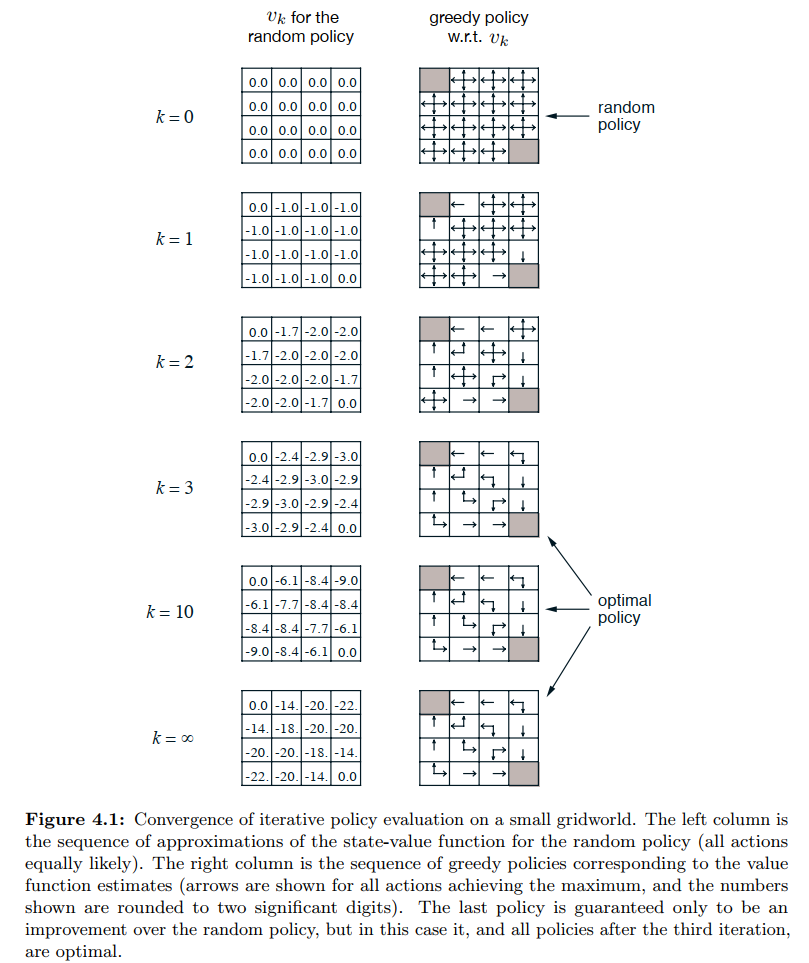

In [7]:
Image(r"images/gridworld_policy_improvement.png", width=600)

## 4.3 Policy Iteration

- We can follow a cyclical chain of: 1) computing a polcy's value and 2) improving the policy via greedy action-selection. Because a finite MDP has only a finite number of policies, this process (**policy iteration**) must converge to an optimal value-function and policy.
$$
\pi_0 \overset{E}{\longrightarrow} v_{\pi0} \overset{I}{\longrightarrow} \pi_1 \overset{E}{\longrightarrow} v_{\pi1} \overset{I}{\longrightarrow} \dots \overset{I}{\longrightarrow} \pi_* \overset{E}{\longrightarrow} v_*
$$
where $E$ represents policy evaluation, and $I$ represents policy improvement.

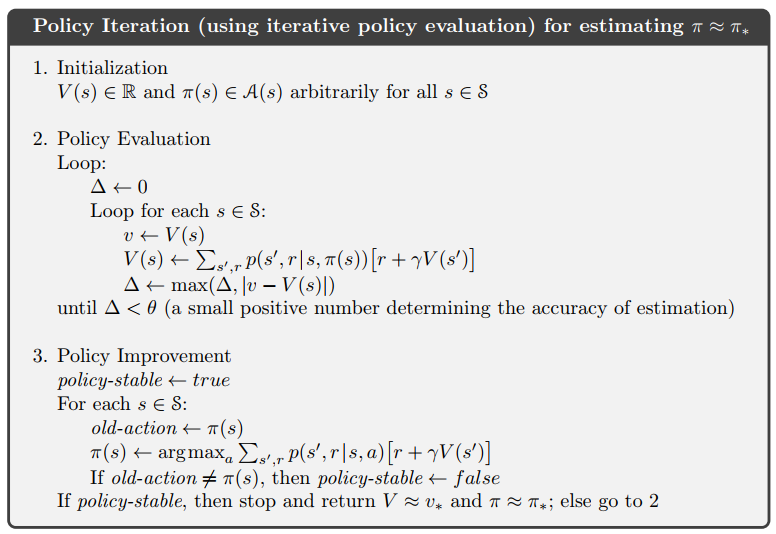

In [10]:
Image(r"images/policy_iteration_pseudocode.png", width=600)

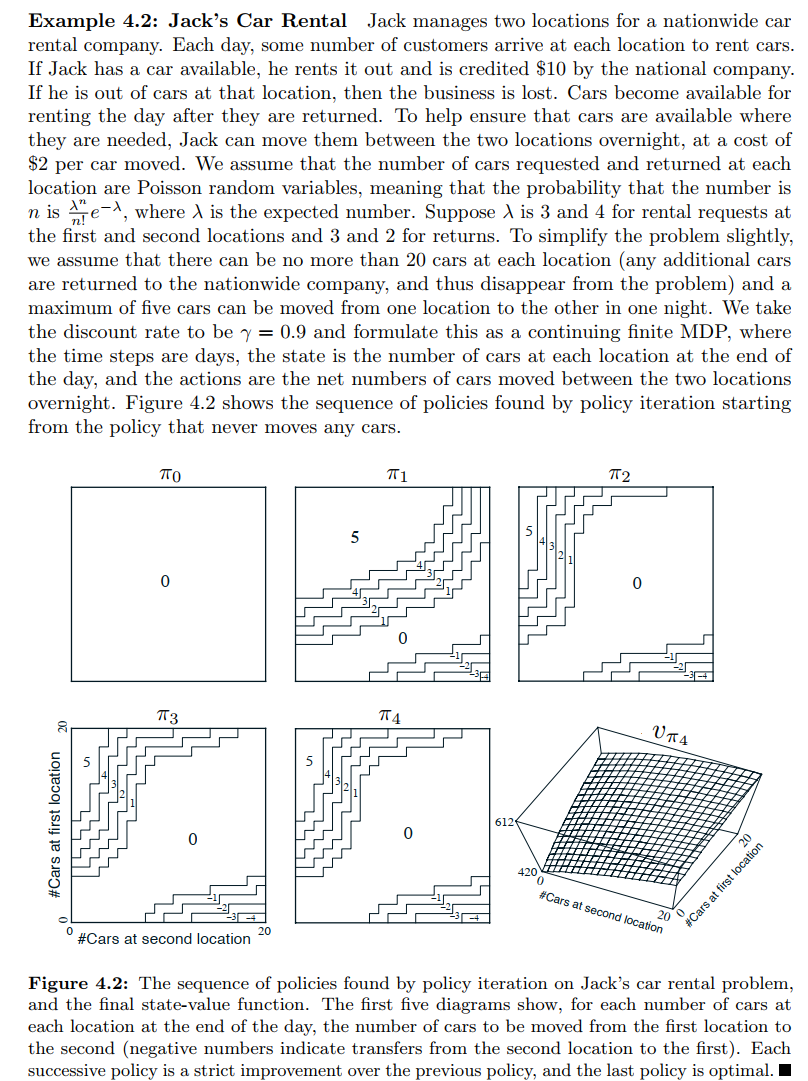

In [11]:
Image(r"images/car_rental_example.png", width=600)

In [8]:
# Implement policy iteration for gridworld example 4.1 and car rental example 4.2

### 4.3 Exercises

## 4.4 Value Iteration

- One drawback of policy iteration is that each iteration involves full policy evaluation, which itself can be a costly computation requiring many sweeps through the state-space. 
- This policy evaluation step can be truncated in several ways without losing the convergence guarantees of policy iteration: one special case is when policy evaluation is stopped after a single sweep through the state-space: this is known as **value iteration**.
- Value iteration can be written as a simple update operation that combines truncated policy evaluation and policy improvement:
$$\begin{equation}\begin{aligned}
v_{k+1}(s) &= \underset{a}{\operatorname{max}} \mathbb{E}_\pi \left[R_{t+1} + \gamma v_k(S_{t+1}) \mid S_t = s, A_t = a \right] \\
&= \underset{a}{\operatorname{max}} \sum_{s', r} p(s', r \mid s, a) \left[r + \gamma v_k(s') \right]
\end{aligned}\end{equation}\tag{4.10}$$
  - Note how this can be obtained by simply turning the state-value Bellman optimality equation (4.1) into an update rule, and also how it is identical to the update in policy evaluation (4.5) except that it only takes the max over all actions.
- Value iteration effectively combines, in each of its state-space sweeps, one sweep of policy evaluation and one sweep of policy improvement.
  - Faster convergence is often achieved by interposing multiple policy evaluation sweeps between each policy improvement sweep.
    - Because the $max$ operation is the only difference between the updates in policy evaluation and value iteration, this just means that we add the $max$ operation to those sweeps in which we want to do policy improvement in the value iteration sweeps. 
    - In general, the entire class of truncated policy iteration algorithms can be thought of as sequences of sweeps, some of which use policy evaluation updates and some of which use value iteration updates.

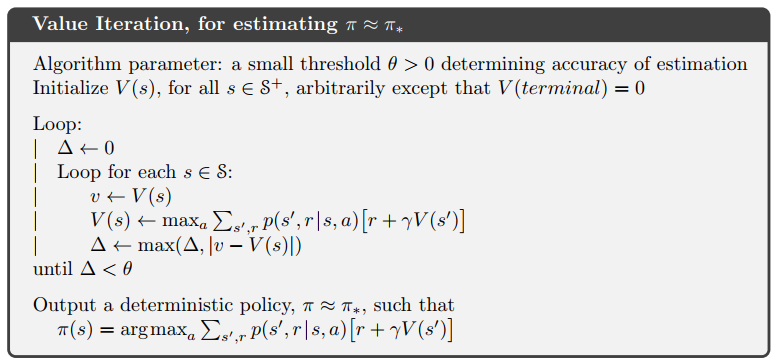

In [12]:
Image(r"images/value_iteration.png", width=600)

### 4.4 Exercises

### 4.5 Asynchronous Dynamic Programming

